In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
import math

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt

In [10]:
### Configuration
dataFile = '../Data/OnshorePVT.csv'

# Data columns
colsInputs = ['OilGravityAPI', 'GasGravity', 'SolutionGasOilRatio', 'ReservoirTemperature', 'InitialReservoirPressure']
colsOutputs = ['Coi']
colsDrop = ['Bob', 'Boi', 'Bgi', 'Bwi', 'Cgi', 'Cwi', 'Cti', 'Coi(Vazquez-Beggs)']

# Split train and test data
testsize = 0.25
cv = 5

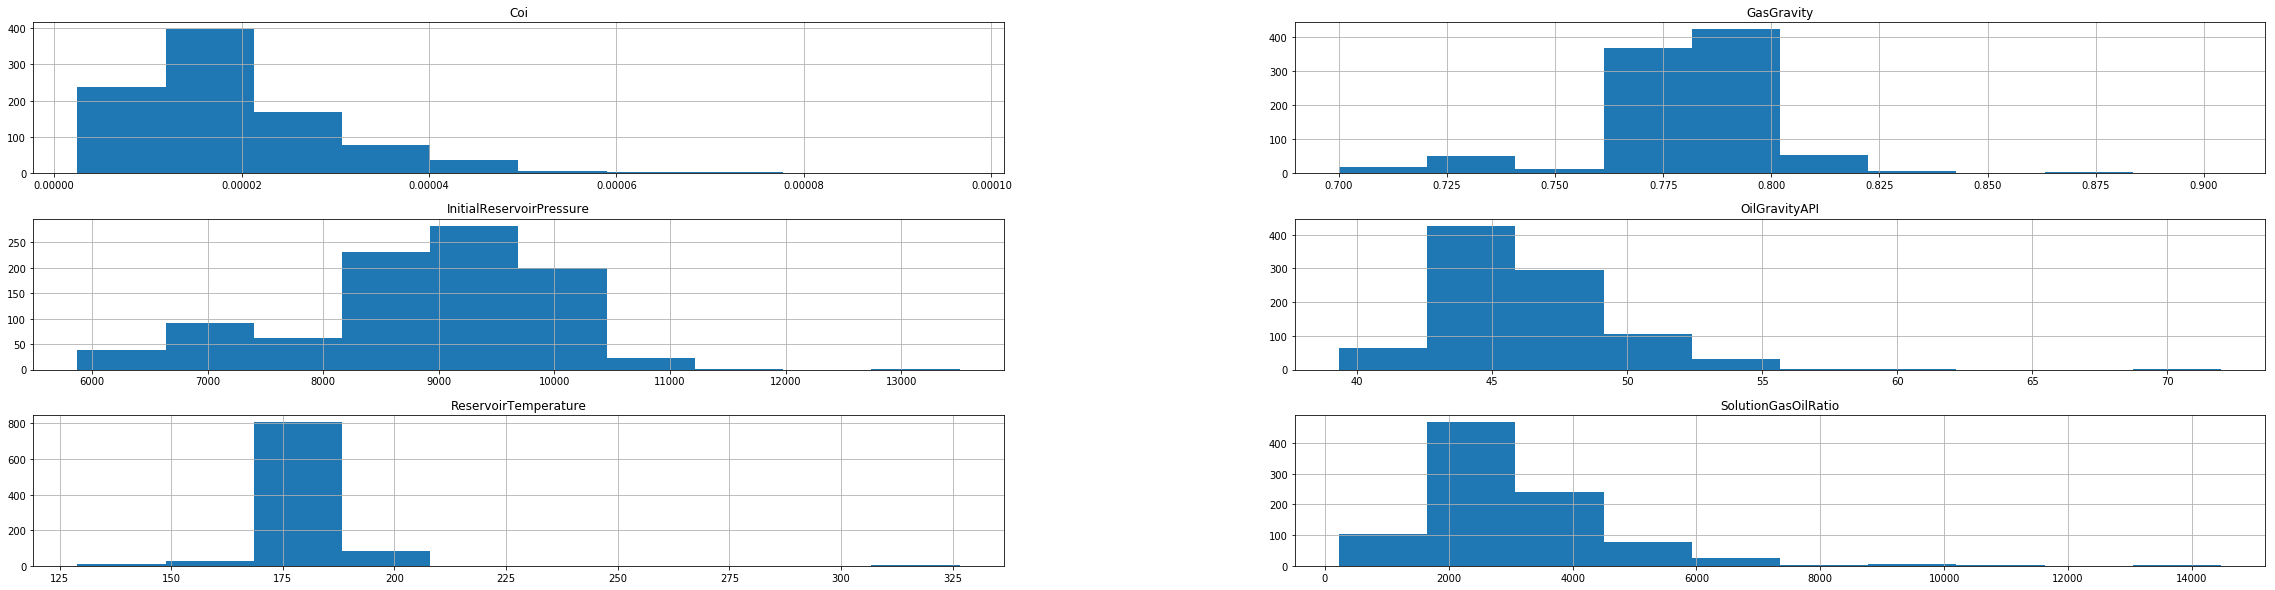

In [11]:
### Data Loading (raw data)
df = pd.read_csv(dataFile)
df = df.drop(columns=colsDrop,axis='columns')

df.hist(figsize=(40,10));

In [12]:
### Data Pre-processing

rawinputs = df[colsInputs]
rawoutputs = df[colsOutputs]

# Scale the data
sc = MinMaxScaler()
inputs = pd.DataFrame(sc.fit_transform(rawinputs))
outputs = pd.DataFrame(sc.fit_transform(rawoutputs))

inputs.columns = rawinputs.columns
outputs.columns = rawoutputs.columns

nInputs = len(inputs.columns)
nOutputs = len(outputs.columns)

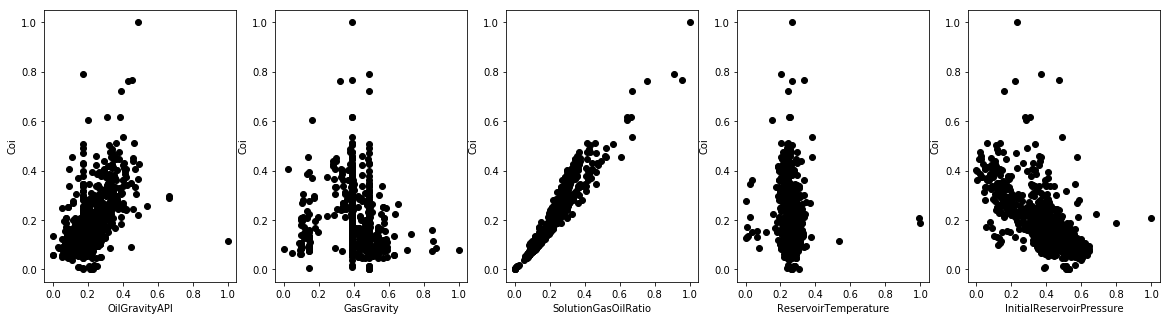

In [13]:
### Exploratory Data Analysis

# Plot inputs vs outputs
fig,ax = plt.subplots(nrows=nOutputs,ncols=nInputs,figsize=(20,5));
ax = ax.flatten()

for i in range(nInputs):
    for j in range(nOutputs):
        ax[i].plot(inputs.iloc[:,i],outputs.iloc[:,j],'ko')
        ax[i].set(xlabel=inputs.columns[i])
        ax[i].set(ylabel=outputs.columns[j])

Train Size = 696, Test Size = 233


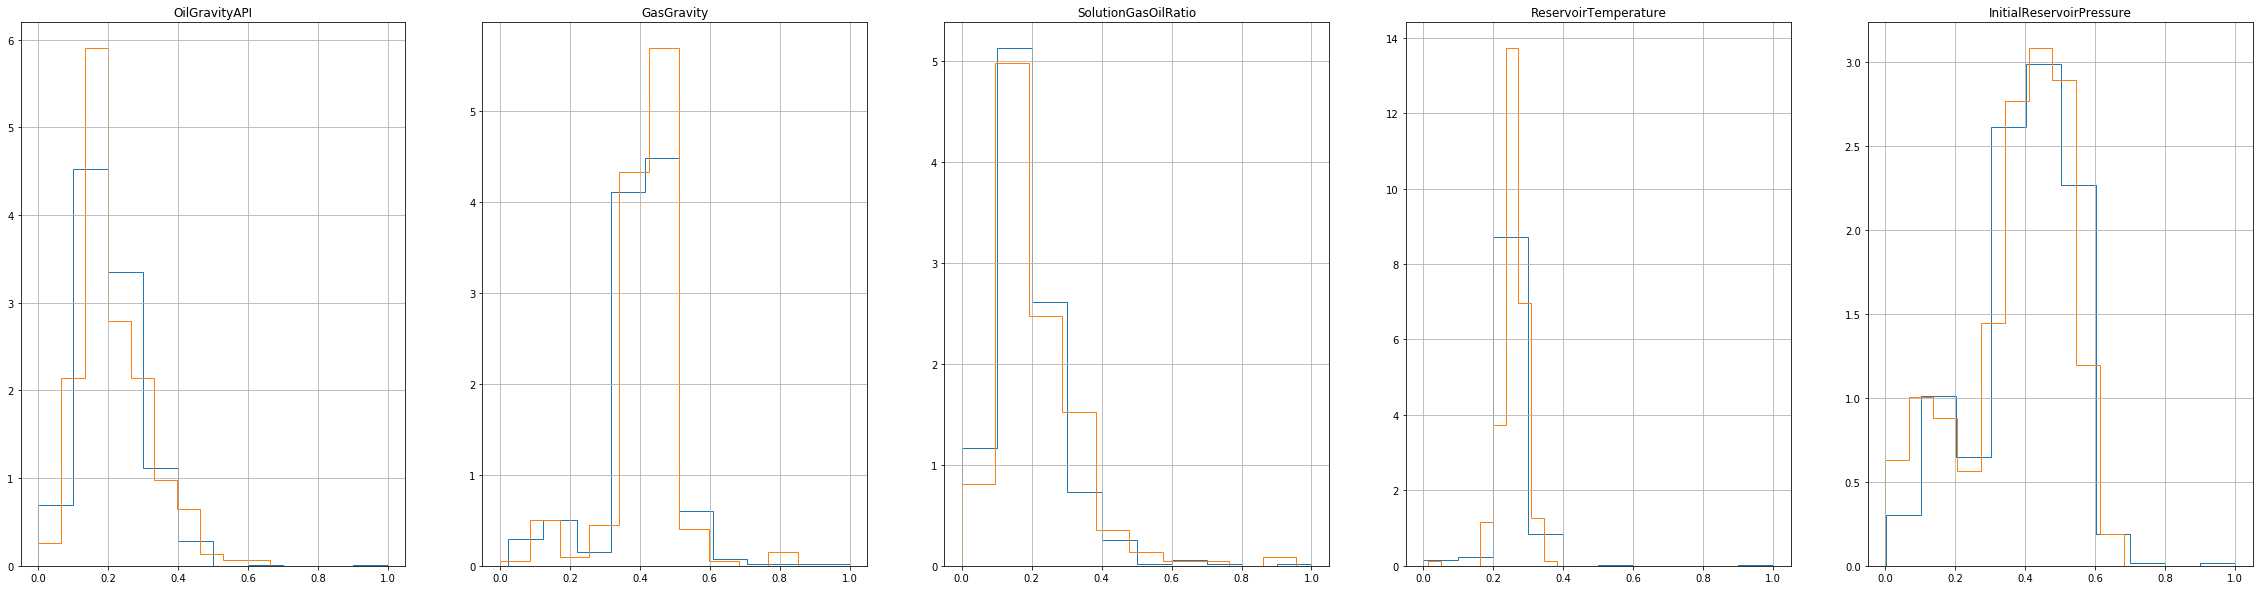

In [14]:
### "Train" and "Test" data split
# Split "Train" and "Test" data
[xtrain,xtest,ytrain,ytest] = train_test_split(inputs,outputs,test_size=testsize,random_state=19)
print("Train Size = " + str(len(xtrain)) + ", Test Size = " + str(len(xtest)))

# Plot train and test data
ncols = 5
nrows = math.ceil(nInputs/ncols)

fig,ax = plt.subplots(nrows=nrows,ncols=ncols);
ax = ax.flatten()

for i in range(nInputs):
    line1 = xtrain.iloc[:,i].hist(figsize=(40,10),ax=ax[i],density=True,histtype='step',fill=False)
    line2 = xtest.iloc[:,i].hist(figsize=(40,10),ax=ax[i],density=True,histtype='step',fill=False)
    ax[i].set(title=xtrain.columns[i])


Train: MAE = 0.002601242448858895, RMSE = 0.004345248503025232, MSE = 1.8881184553043018e-05, R2 = 0.9983630098924052
Test: MAE = 0.003423758515772237, RMSE = 0.005984765873773349, MSE = 3.5817422563882085e-05, R2 = 0.9978248967801646


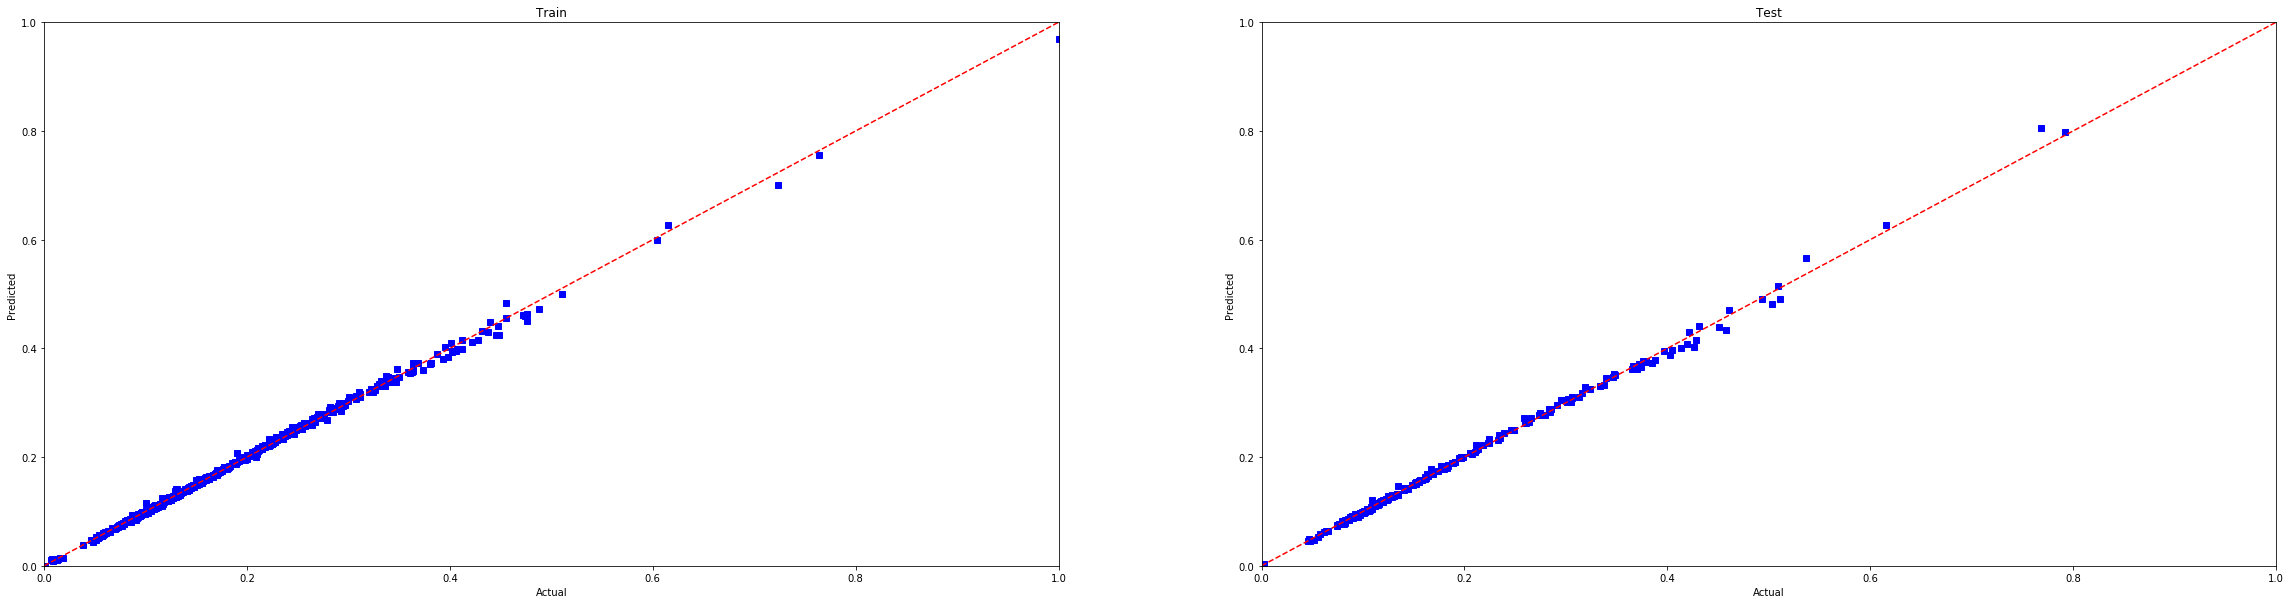

In [16]:
### Model Training

# Model fitting
reg = KernelRidge(alpha=1e-1,kernel='rbf')
regparams = {'alpha':[1e-1, 1e-2]}

reg = GridSearchCV(reg,regparams,cv=cv,n_jobs=4)
model = reg.fit(xtrain,ytrain.values.ravel())

# Model prediction
ytrainpred = model.predict(xtrain)
mae_train = metrics.mean_absolute_error(ytrain,ytrainpred)
mse_train = metrics.mean_squared_error(ytrain,ytrainpred)
rmse_train = math.sqrt(mse_train)
r2_train = metrics.r2_score(ytrain,ytrainpred)
print("Train: MAE = " + str(mae_train) + ", RMSE = " + str(rmse_train) + ", MSE = " + str(mse_train) + ", R2 = " + str(r2_train))

ytestpred = model.predict(xtest)
mae_test = metrics.mean_absolute_error(ytest,ytestpred)
mse_test = metrics.mean_squared_error(ytest,ytestpred)
rmse_test = math.sqrt(mse_test)
r2_test = metrics.r2_score(ytest,ytestpred)
print("Test: MAE = " + str(mae_test) + ", RMSE = " + str(rmse_test) + ", MSE = " + str(mse_test) + ", R2 = " + str(r2_test))

# Display results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(40,10));
ax = ax.flatten()

ll = min(min(ytrainpred),ytrain.min().min(),min(ytestpred),ytest.min().min())
hl = max(max(ytrainpred),ytrain.max().max(),max(ytestpred),ytest.max().max())

ax[0].plot(ytrain,ytrainpred,'bs')
ax[0].plot([ll,hl],[ll,hl],'r--')
ax[0].set(xlabel='Actual')
ax[0].set(ylabel='Predicted')
ax[0].set(title='Train')
ax[0].set_xlim(ll,hl)
ax[0].set_ylim(ll,hl)

ax[1].plot(ytest,ytestpred,'bs')
ax[1].plot([ll,hl],[ll,hl],'r--')
ax[1].set(xlabel='Actual')
ax[1].set(ylabel='Predicted')
ax[1].set(title='Test');
ax[1].set_xlim(ll,hl)
ax[1].set_ylim(ll,hl);
